In [ ]:
!pip install prophet


In [4]:
import pandas as pd

# 1. Load dataset with proper separator
df = pd.read_csv("air_pollution_data.csv", sep=",")

# 2. Strip unwanted spaces in column names
df.columns = df.columns.str.strip()

# 3. Convert 'date' column to datetime (handles both dd-mm-yyyy & d/m/yyyy formats)
df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)

# 4. Convert numeric columns properly
for col in df.columns:
    if col not in ["city", "date"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# 5. Fill missing numeric values with column mean
df.fillna(df.mean(numeric_only=True), inplace=True)

# 6. Final check
print("\n✅ Cleaned Dataset Info:")
print(df.info())

print("\n📊 First 5 Rows:")
print(df.head())

# 7. Example: basic statistics
print("\n🔎 Dataset Statistics:")
print(df.describe(include="all"))



✅ Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23504 entries, 0 to 23503
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   city    23504 non-null  object        
 1   date    14170 non-null  datetime64[ns]
 2   aqi     23504 non-null  int64         
 3   co      23504 non-null  float64       
 4   no      23504 non-null  float64       
 5   no2     23504 non-null  float64       
 6   o3      23504 non-null  float64       
 7   so2     23504 non-null  float64       
 8   pm2_5   23504 non-null  float64       
 9   pm10    23504 non-null  float64       
 10  nh3     23504 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 2.0+ MB
None

📊 First 5 Rows:
        city       date  aqi       co     no    no2      o3    so2   pm2_5  \
0  Ahmedabad 2020-11-30    5   520.71   2.38  16.28  130.18  47.68   65.96   
1  Ahmedabad        NaT    5  1682.

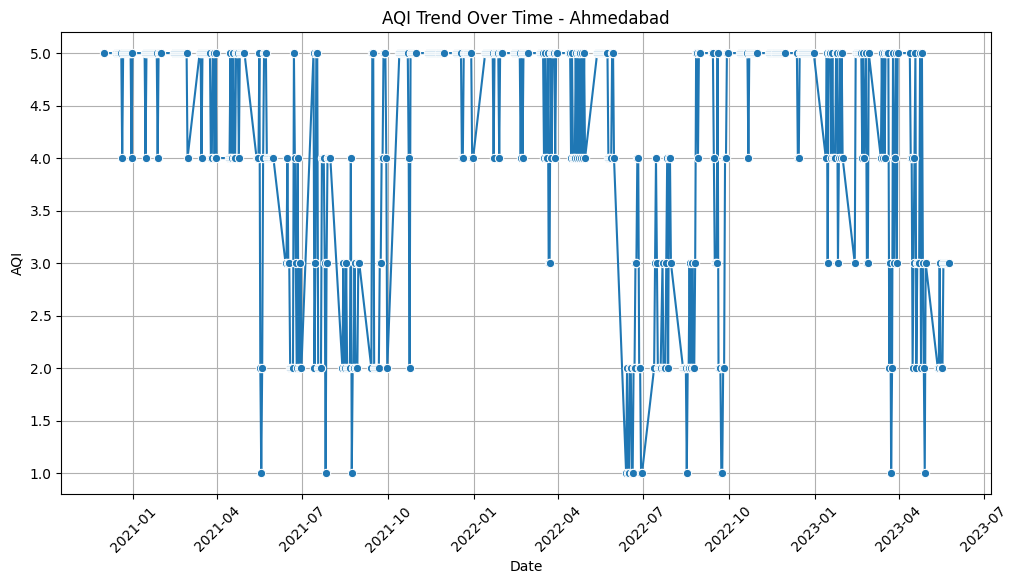

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose a city
city_data = df[df['city'] == 'Ahmedabad']

plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='aqi', data=city_data, marker='o')
plt.title("AQI Trend Over Time - Ahmedabad")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [6]:
# Select target column (example: CO) and rename for Prophet
data = df[['date','co']].rename(columns={'date':'ds','co':'y'})

# Optional: use last 5000 rows for faster training
data = data.tail(5000)

# Split into train & test
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, shuffle=False)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqtoe7upq/j0nsne1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqtoe7upq/ci1xblmd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88038', 'data', 'file=/tmp/tmpqtoe7upq/j0nsne1w.json', 'init=/tmp/tmpqtoe7upq/ci1xblmd.json', 'output', 'file=/tmp/tmpqtoe7upq/prophet_modelf1w7pj5b/prophet_model-20250923143751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:37:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:37:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, 

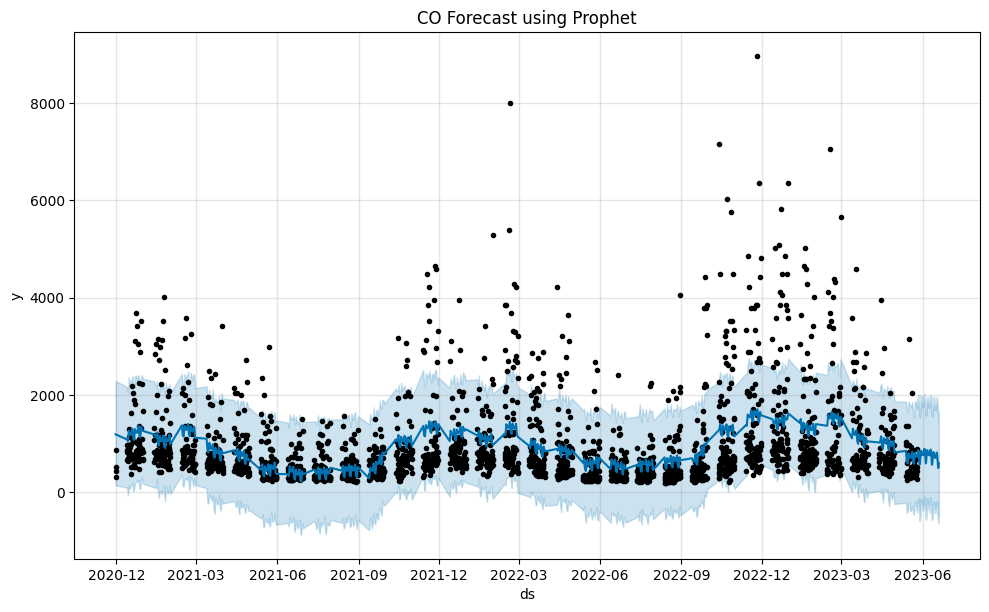

In [8]:
from prophet import Prophet
import matplotlib.pyplot as plt

# Drop NaT / NaN
train = train.dropna(subset=['ds','y'])
test = test.dropna(subset=['ds','y'])

# Initialize and fit Prophet
model = Prophet()
model.fit(train[['ds','y']])

# Predict for test period
future = model.make_future_dataframe(periods=len(test), freq='H')
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("CO Forecast using Prophet")
plt.show()


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Take actual values from test
y_true = test['y'].values

# Take predicted values from forecast (last len(test) rows)
y_pred = forecast['yhat'][-len(test):].values

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

# Print results
print("Model Evaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


Model Evaluation Metrics:
Mean Absolute Error (MAE): 458.21397458051507
Root Mean Squared Error (RMSE): 628.8231327291822
R-squared (R2): -0.043013206701741025



✅ Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23504 entries, 0 to 23503
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   city    23504 non-null  object        
 1   date    14170 non-null  datetime64[ns]
 2   aqi     23504 non-null  int64         
 3   co      23504 non-null  float64       
 4   no      23504 non-null  float64       
 5   no2     23504 non-null  float64       
 6   o3      23504 non-null  float64       
 7   so2     23504 non-null  float64       
 8   pm2_5   23504 non-null  float64       
 9   pm10    23504 non-null  float64       
 10  nh3     23504 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 2.0+ MB
None

📊 First 5 Rows:
        city       date  aqi       co     no    no2      o3    so2   pm2_5  \
0  Ahmedabad 2020-11-30    5   520.71   2.38  16.28  130.18  47.68   65.96   
1  Ahmedabad        NaT    5  1682.

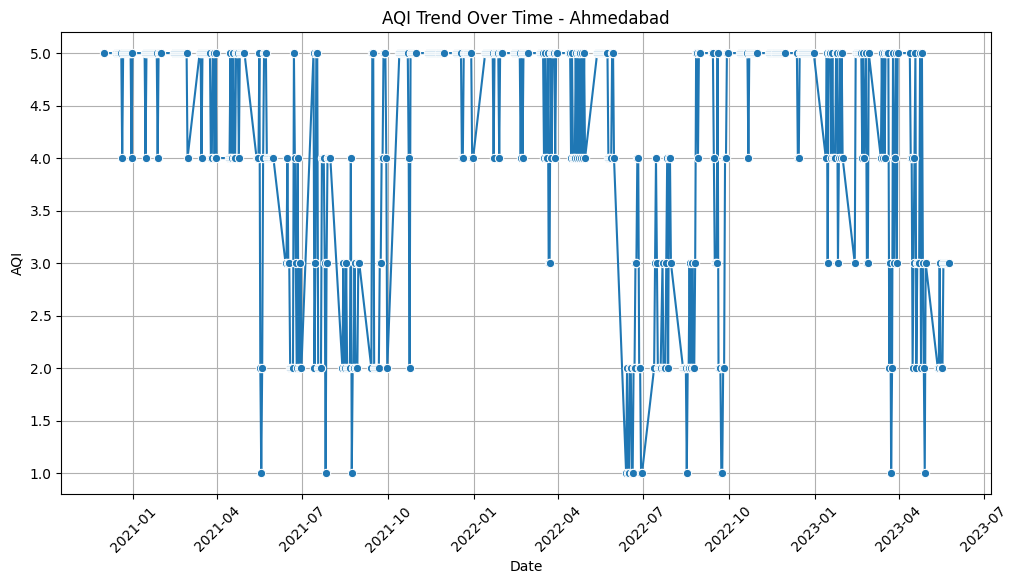

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqtoe7upq/r0ugvjrn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqtoe7upq/35t0h9dc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76631', 'data', 'file=/tmp/tmpqtoe7upq/r0ugvjrn.json', 'init=/tmp/tmpqtoe7upq/35t0h9dc.json', 'output', 'file=/tmp/tmpqtoe7upq/prophet_model5c7i0kmz/prophet_model-20250923145007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:50:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:50:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, 

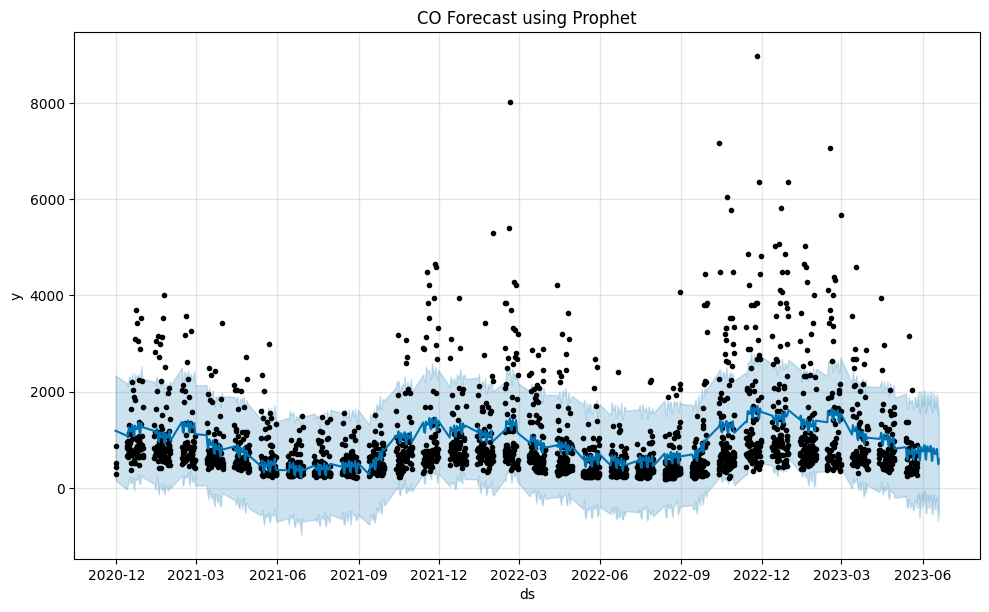

Model Evaluation Metrics:
Mean Absolute Error (MAE): 458.21397458051507
Root Mean Squared Error (RMSE): 628.8231327291822
R-squared (R2): -0.043013206701741025


In [11]:
import pandas as pd
df = pd.read_csv("air_pollution_data.csv", sep=",")
df.columns = df.columns.str.strip()
df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
for col in df.columns:
    if col not in ["city", "date"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")
df.fillna(df.mean(numeric_only=True), inplace=True)

print("\n✅ Cleaned Dataset Info:")
print(df.info())
print("\n📊 First 5 Rows:")
print(df.head())
print("\n🔎 Dataset Statistics:")
print(df.describe(include="all"))

import matplotlib.pyplot as plt
import seaborn as sns
city_data = df[df['city'] == 'Ahmedabad']
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='aqi', data=city_data, marker='o')
plt.title("AQI Trend Over Time - Ahmedabad")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
data = df[['date','co']].rename(columns={'date':'ds','co':'y'})
data = data.tail(5000)
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, shuffle=False)
from prophet import Prophet
import matplotlib.pyplot as plt
train = train.dropna(subset=['ds','y'])
test = test.dropna(subset=['ds','y'])
model = Prophet()
model.fit(train[['ds','y']])
future = model.make_future_dataframe(periods=len(test), freq='H')
forecast = model.predict(future)
model.plot(forecast)
plt.title("CO Forecast using Prophet")
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
y_true = test['y'].values
y_pred = forecast['yhat'][-len(test):].values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print("Model Evaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
